In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.loop import loops as Loops
from meshmaker.delaunay import triangulation
from meshmaker.planargraph import planargraph
from meshmaker.geometry import batch, slide, isnear, near, bbox, sintsxyp
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader, LazyMaterials
from meshmaker.plt import *
from collections import defaultdict
from functools import partial, reduce
from itertools import cycle
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U(0.1))], background=vec3.U(0.5))

In [2]:
class Partition(Base):
    
    def __init__(self, *meshes, **kws):
        super().__init__(**kws)
        self.meshcount = 0
        self.meshes = []
        for mesh in meshes:
            self.av(mesh)

    def __iter__(self):
        """Yield the index, mesh pairs in the partition"""
        for i, mesh in enumerate(self.meshes):
            if mesh is not None:
                yield (i, mesh)
    
    def av(self, mesh, **kws):
        """Add new volume/vertex"""
        m = len(self.meshes)
        self.meshes.append(mesh)
        self.meshcount += 1
        return m
    
    def rv(self, v):
        """Remove volume/vertex v"""
        mesh = self.meshes[v]
        self.meshes[v] = None
        self.meshcount -= 1
        return mesh
    
    def sv(self, O, N, *vs):
        """Split vertices *vs using plane defined by O and N"""
        nvs = []
        for v in vs:
            v = self.rv(v)
            x, y = v.split(O, N)
            nvs.append(self.av(x))
            nvs.append(self.av(y))
        return nvs
    
    def graph(self, Interface=None):
        """Map the adjacency of volumes within the partition
        identifying the intersections of their bounding faces"""
        adjacent = defaultdict(lambda : defaultdict(lambda : {}))
        normals = {i: mesh.face_normals() for i, mesh in self}
        for i, u in self:
            for k, uF in u:
                uN = normals[i][k]
                uL = [u.vertices[x].cp() for x in uF]
                uL.reverse()
                for j, v in self:
                    if i < j:
                        continue
                    for l, vF in v:
                        vN = normals[j][l]
                        vL = [v.vertices[x].cp() for x in vF]
                        if uN.isnear(vN.fp()):
                            if isnear(uL[0].dot(uN), vL[0].dot(uN)):
                                overlap = Loops([uL]).intersect(Loops([vL]))
                                if overlap.loops:
                                    support = dict(support=overlap)
                                    if Interface is not None:
                                        support = Interface(**support)
                                    adjacent[i][j][k] = support
                                    adjacent[j][i][l] = support
        return adjacent
    
    def shell(self):
        """Add node for the exterior of the partition (do last if at all)"""
        shell = Mesh.Union(*filter(None, self.meshes)).fp()
        self._shell = self.av(shell)
        return self._shell
    
    @property
    def shelled(self):
        return getattr(self, '_shell', None)

In [3]:
class Interface(Base):
    """Represent the multi-surface interface of two nodes within a partition"""
    
    def __init__(self, support=None, interior=True):
        self.supports = [Loops((s, )) for s in support.loops]
        self.interior = interior
        self._designed = False

    def design(self, N, doors, windows, **kws):
        """One-time determination of design parameters for scene representation"""
        if self._designed:
            return self
        else:
            self._designed = True
        vertical = not isnear(abs(N.z), 1)
        self._landmarks = []
        self.doorways = []
        for support in self.supports:
            # each support can have 0+ windows/doors...
            # this function is responsible for placing holes
            for loop in support.loops:
                if vertical:
                    if doors:
                        door = doors.pop(0)
                        door = self.door(loop, **door)
                        support.embed(door, mode='clip')
                        #support.embed(door, mode='strict')
                        self.doorways.append((door[0].cp(), door[1].cp()))
                        self._landmarks.append(vec3.com(door))
                    if not self.interior:
                        for window in self.windows(loop, w=1.2, h=0.8, s=0.4):
                            #support.embed(window, mode='strict')
                            self._landmarks.append(vec3.com(window))
        defaulttexture = 'generic_18' if self.interior else 'generic_15'
        self.texture = kws.get('texture', defaulttexture)
        return self

        
    def ___borders(self, loop, dx, dy, X, Y):
        if dx > 0 and dy > 0:
            hole = [loop[0] + X * dx + Y * dy,
                    loop[1] - X * dx + Y * dy,
                    loop[2] - X * dx - Y * dy,
                    loop[3] + X * dx - Y * dy]
            borders = [(loop, (hole, ))]
        elif dx > 0 and dy == 0:
            left = [loop[0].cp(), loop[0] + X * dx,
                    loop[3] + X * dx, loop[3].cp()]
            right = [loop[1] - X * dx, loop[1].cp(),
                     loop[2].cp(), loop[2] - X * dx]
            borders = [(left, ()), (right, ())]            
        elif dx == 0 and dy > 0:
            top = [loop[3] - Y * dy, loop[2] - Y * dy,
                   loop[2].cp(), loop[3].cp()]
            bottom = [loop[0].cp(), loop[1].cp(),
                      loop[1] + Y * dy, loop[0] + Y * dy]
            borders = [(top, ()), (bottom, ())]
        elif dx == 0 and dy == 0:
            borders = []
        else:
            print(dx, dy)
            raise
        return borders
        
    def tiles(self, loop, chunk_w=1.01, chunk_h=1.01, max_nx=None, max_ny=None):
        """Chunk a rectangular space into a grid"""
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx
                for y in range(0, ny):
                    y = y * chunk_h + dy
                    positions.append(loop[0] + X * x + Y * y)
        
        return positions
        
        #if positions:
        #    assert (nx > 0 and ny > 0)
        #    return positions, self.borders(loop, dx, dy, X, Y)
        #else:
        #    return positions, [(loop, ())]
    
    @staticmethod
    def loopO(loop):
        zmin = min(p.z for p in loop)
        for i, (u, v) in enumerate(slide(loop, 2)):
            if isnear(u.z, zmin) and isnear(v.z, zmin):
                return i

    def door(self, support, w=0.2, h=0.3, s=0.1, x=0.5):
        o = self.loopO(support)
        support = support[o:] + support[:o]
        T = (support[1] - support[0]).nrm()
        u = support[0].lerp(support[1], x) - (T * (w / 2)) + vec3.Z(s)
        v = u + (T * w)
        door = [u, v, v + vec3.Z(h), u + vec3.Z(h)]
        return door
    
    def windows(self, support, w=0.2, h=0.2, s=0.2):
        o = self.loopO(support)
        support = support[o:] + support[:o]
        W = (support[1] - support[0]).mag()
        H = (support[3] - support[0]).mag()
        chunk_w, chunk_h = min(W, 1.2 * w), min(H, 1.2 * (h + s))
        positions = self.tiles(support, chunk_w, chunk_h)
        T = (support[1] - support[0]).nrm()
        windows = []
        for o in positions:
            window = [o + (T * ((chunk_w - w) / 2)) + vec3.Z(s)]
            window.append(window[0] + (T * w))
            window.append(window[1] + vec3.Z(h))
            window.append(window[0] + vec3.Z(h))
            windows.append(window)
        return windows

    def setportals(self, loop):
        """Make copies of ploops which are properly coplanar with loop"""
        lN = Loops([loop]).N
        aligned = []
        for support in self.supports:
            for ploop in support.holes:
                ploop = [p.cp() for p in ploop]
                pN = Loops([ploop]).N
                if not lN.isnear(pN):
                    ploop.reverse()
                inset = [p.cp() for p in ploop]
                dN = lN * (loop[0].dot(lN) - ploop[0].dot(lN))
                if not isnear(dN.mag(), 0):
                    dN.trnps(ploop)
                    aligned.append((ploop, inset))
                else:
                    aligned.append((ploop, None))
        return aligned
    
    def scene(self, loop):
        """Return a TForm for the portal's representation and
        the set of portal boundaries coplanar with loop
        (potentially called for each side of a wall)"""        
        #positions, borders = self.tiles(support, 1, 2)
        ploops = []
        meshes = defaultdict(list)
        for portal, support in self.setportals(loop):
            ploops.append(portal)
            if support is not None:
                mesh = Mesh()
                mesh.bridge(portal, support)
                meshes[self.texture].append(mesh)                
        #for p in self._landmarks:
        #    meshes['generic_18'].append(Mesh.cube_mesh(0.02))
        #    p.trnps(meshes['generic_18'][-1].vertices)
        tf = TForm(models=[Model(meshes=meshes)])
        return tf, ploops


def Wall(interfaces, texture, ptexture):

    def meta(control, faces):
        assert len(faces) == 1
        loop = [control.vertices[v] for v in control.faces[faces[0]]]
        
        # TODO: support different types of interface...
        #       closed, open, 1+ doors/windows
        
        meshes = defaultdict(list)
        children = []
        
        ploops = []
        for interface in interfaces:
            tf, iploops = interface.scene(loop)
            children.append(tf)
            ploops.extend(iploops)
            
        try:
            mesh = Mesh()
            py = (
                [p.cp().quant() for p in loop],
                [[p.cp().quant() for p in ib] for ib in ploops])
            mesh.apy(py, 0.0001, None)
            meshes[texture].append(mesh)
        except:
            print(((loop, ploops), ))

        return TForm(models=[Model(meshes=meshes)], children=children)

    return meta


def show_graph(nodes, edges):
    """Represent topology of a graph of mesh nodes"""
    # nodes is a dict of (int, mesh) pairs
    # edges is a list of (i, j) int pairs, indices in nodes
    meshes = defaultdict(list)
    for i, node in nodes.items():
        cube = Mesh.cube_mesh(0.1)
        vec3.com(node.vertices).trnps(cube.vertices)
        meshes['generic_8'].append(cube)
    def wires(tf, nodes=None, edges=None):
        wires = []
        for i, j in edges:
            wires.append((vec3.com(nodes[i].vertices),
                          vec3.com(nodes[j].vertices)))
        return wires        
    meshes[next(meshes.keys().__iter__())][0].wires =\
        partial(wires, nodes=nodes, edges=edges)
    return TForm(models=[Model(meshes=meshes)])


texturecycle = cycle((f'generic_{i}' for i in range(8, 14)))
nexttex = lambda : next(texturecycle)


class Stairs(MetaMesh):
    
    def scene(self):
        pass


def scaffold(node, doorways, zmin_step=0.3):
    zmin = min([p.z for p in node.vertices])
    ncom = vec3.com(node.vertices)
    rims = []
    for u, v in doorways:
        if u.z - zmin < zmin_step:
            continue
        N = (v - u).crs(vec3.Z()).nrm()
        if ncom.dot(N) - u.dot(N) < 0:
            u, v = v, u
            N = N.fp()
        rims.append((u, v))    
    for u, v in rims:
        T = (v - u).nrm()
        N = T.crs(vec3.Z())
        u = u - (T * 0.1) + (N * 0.1)
        v = v + (T * 0.1) + (N * 0.1)
        x, y = v + (N * 1.6), u + (N * 1.6)
        platform = [v, u, y, x]
        node.af(platform, meta='generic_3')


def show_partition(partition, doors={}, windows={}, wallwidth=0.1):
    adjacent = partition.graph(Interface)
    shell = partition.shelled
    
    ptexture = nexttex()
    nodes = {}
    for i in adjacent:
        ntexture = nexttex()
        nodes[i] = partition.meshes[i].cp().fp()
        nodes[i].offset(-wallwidth * 0 if i == shell else -wallwidth)
        doorways = []
        for k, face in nodes[i]:
            interfaces = []
            for j in adjacent[i]:
                if k in adjacent[i][j]:
                    iface = adjacent[i][j][k]
                    iface.interior = not (i == shell or j == shell)
                    
                    N = nodes[i].face_normals()[k]
                    idoors = doors.get((i, j), doors.get((j, i), []))
                    iwindows = windows.get((i, j), windows.get((j, i), []))                    
                    interfaces.append(iface.design(N, idoors, iwindows))
                    doorways.extend(iface.doorways)

            wall = Wall(interfaces, ntexture, ptexture)
            wall.__name__ = f'metawall-<{i},{k}>'
            nodes[i].meta[k] = wall

        scaffold(nodes[i], doorways)
        #stairs = Stairs(doorways)
    
    edges = [(i, j) for i in adjacent for j in adjacent[i]]

    mr = TForm(metas=[MetaMesh(node) for i, node in nodes.items()])
    mr.add(show_graph(nodes, edges))
    ms = MetaScene(mr)
    return ms

In [4]:
X, Y, Z = vec3.X(), vec3.Y(), vec3.Z()
wallwidth = 0.1
door = dict(w=0.8, h=1.6, s=-0.2 + wallwidth)

control = Mesh.cube_mesh()

vec3.U(0.5).sclps(vec3.Z(1).trnps(control.vertices))

p = Partition()
x = p.av(control)

doors = defaultdict(list)
windows = defaultdict(list)

w, x = p.sv(vec3.X(0.25), X, x)

floors = []
for s in vec3.O().line(vec3.Z(), 3):
    x, y = p.sv(s, Z, x)
    floors.append(y)
else:
    floors.append(x)

for i in (1, 2, 3):
    floors[i], new = p.sv(vec3.Y(0.25), Y, floors[i])
    doors[(floors[i], new)].append(door)

for i, f in enumerate(floors):
    doors[(w, f)].append(door)

shell = p.shell()
doors[(w, shell)].append(door)

R = 6
H = len(floors) * 2
S = vec3(R, R, H)
for m in filter(None, p.meshes):
    S.sclps(m.vertices)

ms = show_partition(p, doors, windows, wallwidth)
show(ms)

clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_3 (../resources/textures/generics/generic_3.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_9 (../resources/textures/generics/generic_9.png)


In [5]:
def example_metas():
    a = vec3.O(   ).ring(5, 4, True)
    b = vec3.Z(1.0).ring(5, 4, True)
    c = vec3.Z(1.0).ring(4, 4, True)
    d = vec3.Z(0.9).ring(5, 4, True)
    e = vec3.Z(0.9).ring(4, 4, True)
    
    tex = ParamMesh.textured(texture='generic_4')

    mesh = Mesh()
    mesh._railings = []
    mesh._stairs = []


    bot = mesh.af(a, meta=tex)
    top = mesh.apy((b, (c, )), meta=tex)
    mesh.apy((d[::-1], (e[::-1], )), meta=tex)
    mesh.bridge(d, b)
    mesh.bridge(c, e)

    sup = mesh.perimeter(top)[1]
    mesh._railings.extend(sup)
    mesh._stairs.append((bot, sup[0]))
    mesh._stairs.append((bot, sup[2]))


    ground = MetaMesh(mesh)
    stairs = Stairs(mesh)
    railing = Railing(mesh)
    return [ground, stairs, railing]

m = example_metas()
r = TForm(metas=m)
ms = MetaScene(r)
show(ms)

AttributeError: 'NoneType' object has no attribute 'parent'

In [ ]:
r = 4
control = Mesh.cube_mesh(r)
p = Partition()
x = p.av(control)
x, y = p.sv(vec3.Z(1), vec3.Z(), x)
x, z = p.sv(vec3.Z(1), vec3.X(), x)
w, z = p.sv(vec3.Z(1), vec3.Y(), z)
y, a = p.sv(vec3.Z(1), vec3.U().xy().nrm(), y)
p.rv(w)
p.rv(y)
p.shell()
ms = show_partition(p)
show(ms)

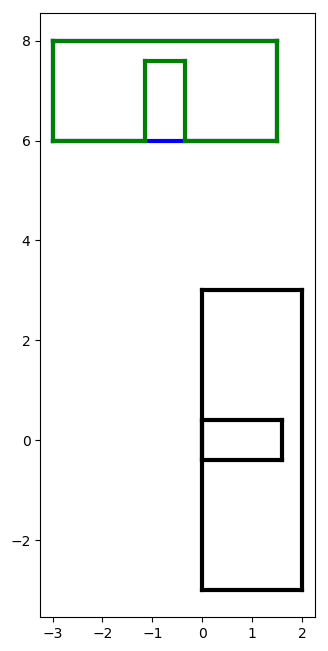

In [5]:
from meshmaker.geometry import loop_normal

#py = ([vec3(-3.0000, -3.0000, 2.0000), vec3(-3.0000, -3.0000, 0.0000), vec3(-3.0000, 3.0000, 0.0000), vec3(-3.0000, 3.0000, 2.0000)], [[vec3(-3.0000, 2.6500, 1.8500), vec3(-3.0000, 1.8500, 1.8500), vec3(-3.0000, 1.8500, 0.8500), vec3(-3.0000, 2.6500, 0.8500)], [vec3(-3.0000, 1.9000, 1.8500), vec3(-3.0000, 1.1000, 1.8500), vec3(-3.0000, 1.1000, 0.8500), vec3(-3.0000, 1.9000, 0.8500)], [vec3(-3.0000, 1.1500, 1.8500), vec3(-3.0000, 0.3500, 1.8500), vec3(-3.0000, 0.3500, 0.8500), vec3(-3.0000, 1.1500, 0.8500)], [vec3(-3.0000, 0.4000, 1.8500), vec3(-3.0000, -0.4000, 1.8500), vec3(-3.0000, -0.4000, 0.8500), vec3(-3.0000, 0.4000, 0.8500)], [vec3(-3.0000, -0.3500, 1.8500), vec3(-3.0000, -1.1500, 1.8500), vec3(-3.0000, -1.1500, 0.8500), vec3(-3.0000, -0.3500, 0.8500)], [vec3(-3.0000, -1.1000, 1.8500), vec3(-3.0000, -1.9000, 1.8500), vec3(-3.0000, -1.9000, 0.8500), vec3(-3.0000, -1.1000, 0.8500)], [vec3(-3.0000, -1.8500, 1.8500), vec3(-3.0000, -2.6500, 1.8500), vec3(-3.0000, -2.6500, 0.8500), vec3(-3.0000, -1.8500, 0.8500)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.4000, 2.9000, 1.9000), vec3(1.4000, 2.9000, 0.1000), vec3(1.4000, -2.9000, 0.1000), vec3(1.4000, -2.9000, 1.9000)], [[vec3(1.4000, 0.4000, 0.1000), vec3(1.4000, -0.4000, 0.1000), vec3(1.4000, -0.4000, 1.7000), vec3(1.4000, 0.4000, 1.7000)]])

py = ([vec3(2.0000, 3.0000, -1.5000), vec3(0.0000, 3.0000, -1.5000), vec3(0.0000, -3.0000, -1.5000), vec3(2.0000, -3.0000, -1.5000)],
    [[vec3(0.0000, 0.4000, -1.5000), vec3(0.0000, -0.4000, -1.5000), vec3(1.6000, -0.4000, -1.5000), vec3(1.6000, 0.4000, -1.5000)]])

l1 = [[vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)]]
l2 = [[vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(-1.1500, 6.0000, -1.5000), vec3(-1.1500, 7.6000, -1.5000), vec3(-0.3500, 7.6000, -1.5000), vec3(-0.3500, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)]]

#q = quat.uu(loop_normal(py[0]), vec3.Z())
#q.rot(py[0])
#for h in py[1]:
#    q.rot(h)

#for h in py[1]:
#    quat.av(-np.pi / 2, vec3.Y()).rot(h)

#lp = Loop.from_polygon(py[0], py[1])

f, ax = plot()
ax.set_aspect(1)
#lp.plot(ax)

plot_loop(ax, py[0])
for h in py[1]:
    plot_loop(ax, h)

for h in l1:
    plot_loop(ax, h, col='b')
for h in l2:
    plot_loop(ax, h, col='g')
    
#plot_loop(ax, [vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(-1.1500, 6.0000, -1.5000), vec3(-1.1500, 7.6000, -1.5000), vec3(-0.3500, 7.6000, -1.5000), vec3(-0.3500, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)], col='g')

In [ ]:
def loopO(loop):
    

a = [vec3(0, 0, 0), vec3(1, 0, 0), vec3(1, 0, 1), vec3(0, 0, 1)]

# TODO: support layers/groups for showing/hiding meshes in mgl window 

In [ ]:
# break edges where topologically sensical

r = 4
control = Mesh.cube_mesh(r)
p = Partition()
x = p.av(control)
x, y = p.sv(vec3.Z(1), vec3.Z(), x)
x, z = p.sv(vec3.Z(1), vec3.X(), x)
w, z = p.sv(vec3.Z(1), vec3.Y(), z)
y, a = p.sv(vec3.Z(1), vec3.U().xy().nrm(), y)
p.rv(w)
p.rv(y)

shell = Mesh.Union(*filter(None, p.meshes))
print(shell.faces)

def clean(self):
    for f, face in self:
        print(f, len(face))
    return self

shell = clean(shell)

shell.offset(0.1)

show(TForm(models=[Model(meshes={'generic_8': [shell]})]))

In [ ]:
a = Mesh.cube_mesh()
b = Mesh.cube_mesh()
vec3.U(-0.5).trnps(a.vertices)
vec3.U( 0.5).trnps(b.vertices)
show(TForm(models=[Model(meshes={'generic_11': [a], 'generic_10': [b]})]))
#show([a, b])

In [ ]:
show(a.union(b))
show(b.union(a))
show(a.difference(b))
show(b.difference(a))
show(a.intersect(b))
show(b.intersect(a))